In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc,precision_recall_curve,plot_roc_curve,plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix,plot_confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA,KernelPCA

In [3]:
def plot_classification_performance(clf,X,y_true, step, binary):
   
    '''
    performance of classification is evaluated with:
    
    1) accuracy: (TP + TN)/(TP + TN + FP + FN)
    
    2) precision: TP / (TP + FP)
    
    3) recall (sensitivity, true positive rate): TP / (TP + FN)
    
    4) f_score: 2 * precision * recall / (precision + recall)
    
    5) precsion_recall_curve: x-axis: precision, y-axis: recall
    
    6) roc_curve: x-axis: true positive rate, y-axis: false positive rate
                
                true positive rate (recall, sensitivity): TP / (TP + FN)
                false positive rate (fall out, 1 - specificity): FP / (FP + TN) = 1 - specificity = 1 - TN / (TN + FP)
                
                specifity (or true negative rate): TN / (TN + FP) 
    
    7) confusion_matrix = [TP  FP
                           FN  TN]  
    
    '''
    
    accuracy = clf.score(X,y_true)
    
    if binary:
    
       
    
        y_pred = clf.predict(X)
        
        report = classification_report(y_true,y_pred)
        print('{} Classification Report'.format(step))
        print(report)
    
    
        plot_roc_curve(clf, X, y_true)
        plt.title('{} ROC curve'.format(step))
    
        plot_precision_recall_curve(clf, X, y_true)
        plt.title('{} Precision Recall curve'.format(step))
        
        
        plot_confusion_matrix(clf,X, y_true)
        plt.title('{} Confusion Matrix'.format(step))
        
    else:
        
        
        n_classes = len(clf.classes_)
        #y_score = clf.predict_proba(X)
        y_score = clf.decision_function(X)
        y_pred = clf.predict(X)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
    
        precision = dict()
        recall = dict()
        f_score = dict()
    
        y_true_dummies = pd.get_dummies(y_true, drop_first = False).values
    
        for i in range(n_classes):
        
            fpr[i], tpr[i], _ = roc_curve(y_true_dummies[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
            precision[i], recall[i],_ =  precision_recall_curve(y_true_dummies[:, i], y_score[:, i])
            
        report = classification_report(y_true,y_pred)
        print('{} Classification Report'.format(step))
        print(report)
                                                                
       
    
        figsize=(8, 5)
        fig, ax = plt.subplots(figsize = figsize)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('{} ROC curve'.format(step))
        
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], label = 'Class {} (area = {:.2f})'.format(i, roc_auc[i]))
    
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
        plt.show()
    
        figsize=(8, 5)
        fig, ax = plt.subplots(figsize = figsize)

        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title('{} Precision Recall curve'.format(step))
        
        for i in range(n_classes):
            ax.plot(precision[i], recall[i], label = 'Class {}'.format(i))
        
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
        plt.show()
    
        figsize=(8, 5)
        plot_confusion_matrix(clf,X,y_true)
        
        
    

## 1. Get the Dataset

In [4]:
breast_cancer_dataset = datasets.load_breast_cancer()

In [5]:
breast_cancer_dataset.target_names

array(['malignant', 'benign'], dtype='<U9')

In [6]:
X_df = pd.DataFrame(breast_cancer_dataset.data)
X_fn = breast_cancer_dataset.feature_names
X_df.columns = X_fn


y_df = pd.DataFrame(breast_cancer_dataset.target)
y_df.columns = ['cancer_type']

In [7]:
X_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [8]:
y_df

,cancer_type
0,0
1,0
2,0
3,0
4,0
...,...
564,0
565,0
566,0
567,0


## 2. Data Preprocessing

In [9]:
# features scaling

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_df.values)

X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns = X_df.columns

y = y_df

(array([212.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 357.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

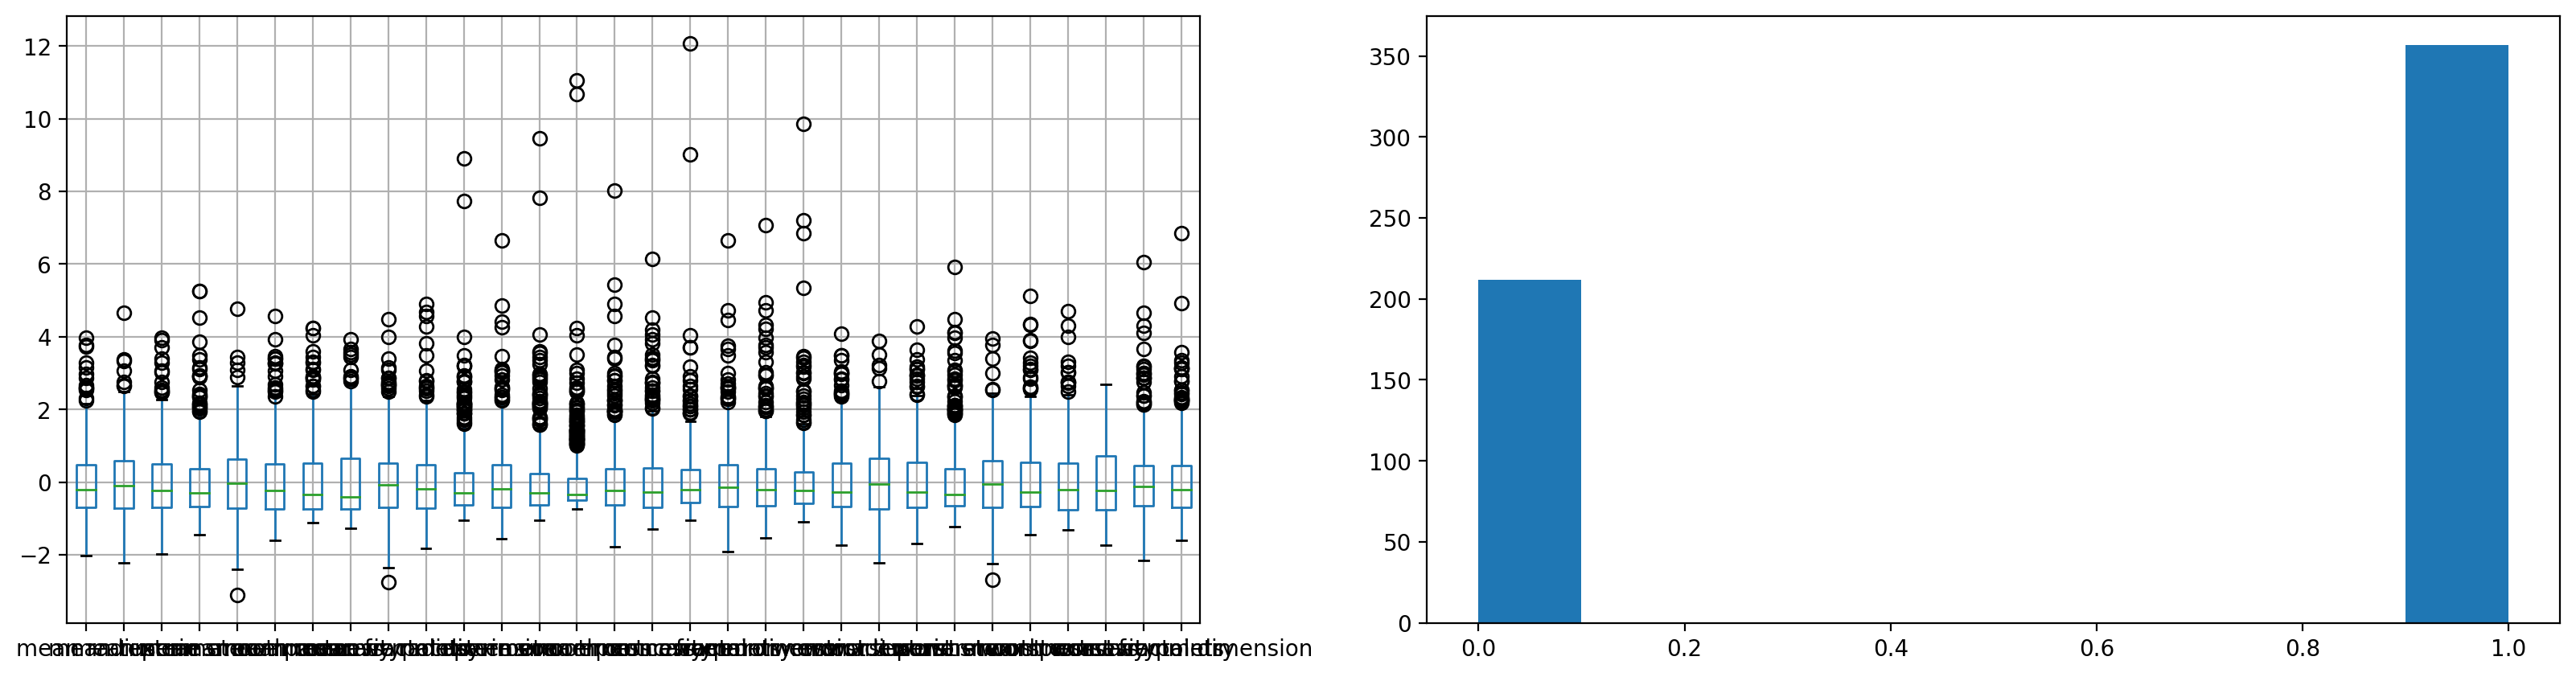

In [10]:
# features distribution after scaling

fig = plt.figure(figsize = (20,5), dpi = 200)

ax = fig.add_subplot(1,2,1)
X_scaled.boxplot()

ax = fig.add_subplot(1,2,2)
plt.hist(y)

In [11]:
# function to remove the outliers from the dataset (data which fall outside of the whiskers in the box plot)
# the outliers are removed for each feature separately. It can happen that data that are outliers
# for a certain feature are not outliers for another feature. 
# The threshold to consider data outliers or not is defined by q. 

# upper quartile or 75h percentile (Q3): value for which 75% of the data are less than this value (upper threshold of the box)
# lower quartile or 25th percentile (Q1): value for which 25% of the data are less than this value (lower theshold of the box)
# iqr: distance between the upper and lower quartile: Q3 - Q1

# upper whisker: Q3 + q*iqr
# lower whisler: Q1 - q*iqr

# data > upper whisker or < lower whisker : outliers

# q controls the amount of data to consider as outliers

def get_remove_outliers(X,y,q):
    
    data = np.column_stack((X.values,y.values))
    
    for j in range(data.shape[1]):
    
        median = np.median(data[:,j])
        
        upper_quartile = np.percentile(data[:,j], 75)
        lower_quartile = np.percentile(data[:,j], 25)

        iqr = upper_quartile - lower_quartile
        upper_whisker = (data[:,j][data[:,j] <= upper_quartile + q * iqr]).max()
        lower_whisker = (data[:,j][data[:,j] >= lower_quartile - q * iqr]).min()
        
        data_clean = data[data[:,j] <= upper_whisker]
        data_clean = data_clean[data_clean[:,j] >= lower_whisker]
        
        data = data_clean
        
        
    X_clean = pd.DataFrame(data_clean[:,:data_clean.shape[1] - 1])
    X_clean.columns = X.columns
    
    y_clean = pd.DataFrame(data_clean[:,data_clean.shape[1] - 1])
    y_clean.columns = y.columns
    
    return X_clean,y_clean

In [12]:
q = 3

X_clean, y_clean = get_remove_outliers(X_scaled,y, q)

fraction_removed_outliers =  1 - X_clean.shape[0] / X_scaled.shape[0]

print('Removed {:.1f} % data'.format(fraction_removed_outliers * 100))

Removed 13.2 % data


Text(0.5, 1.0, 'y after removing outliers')

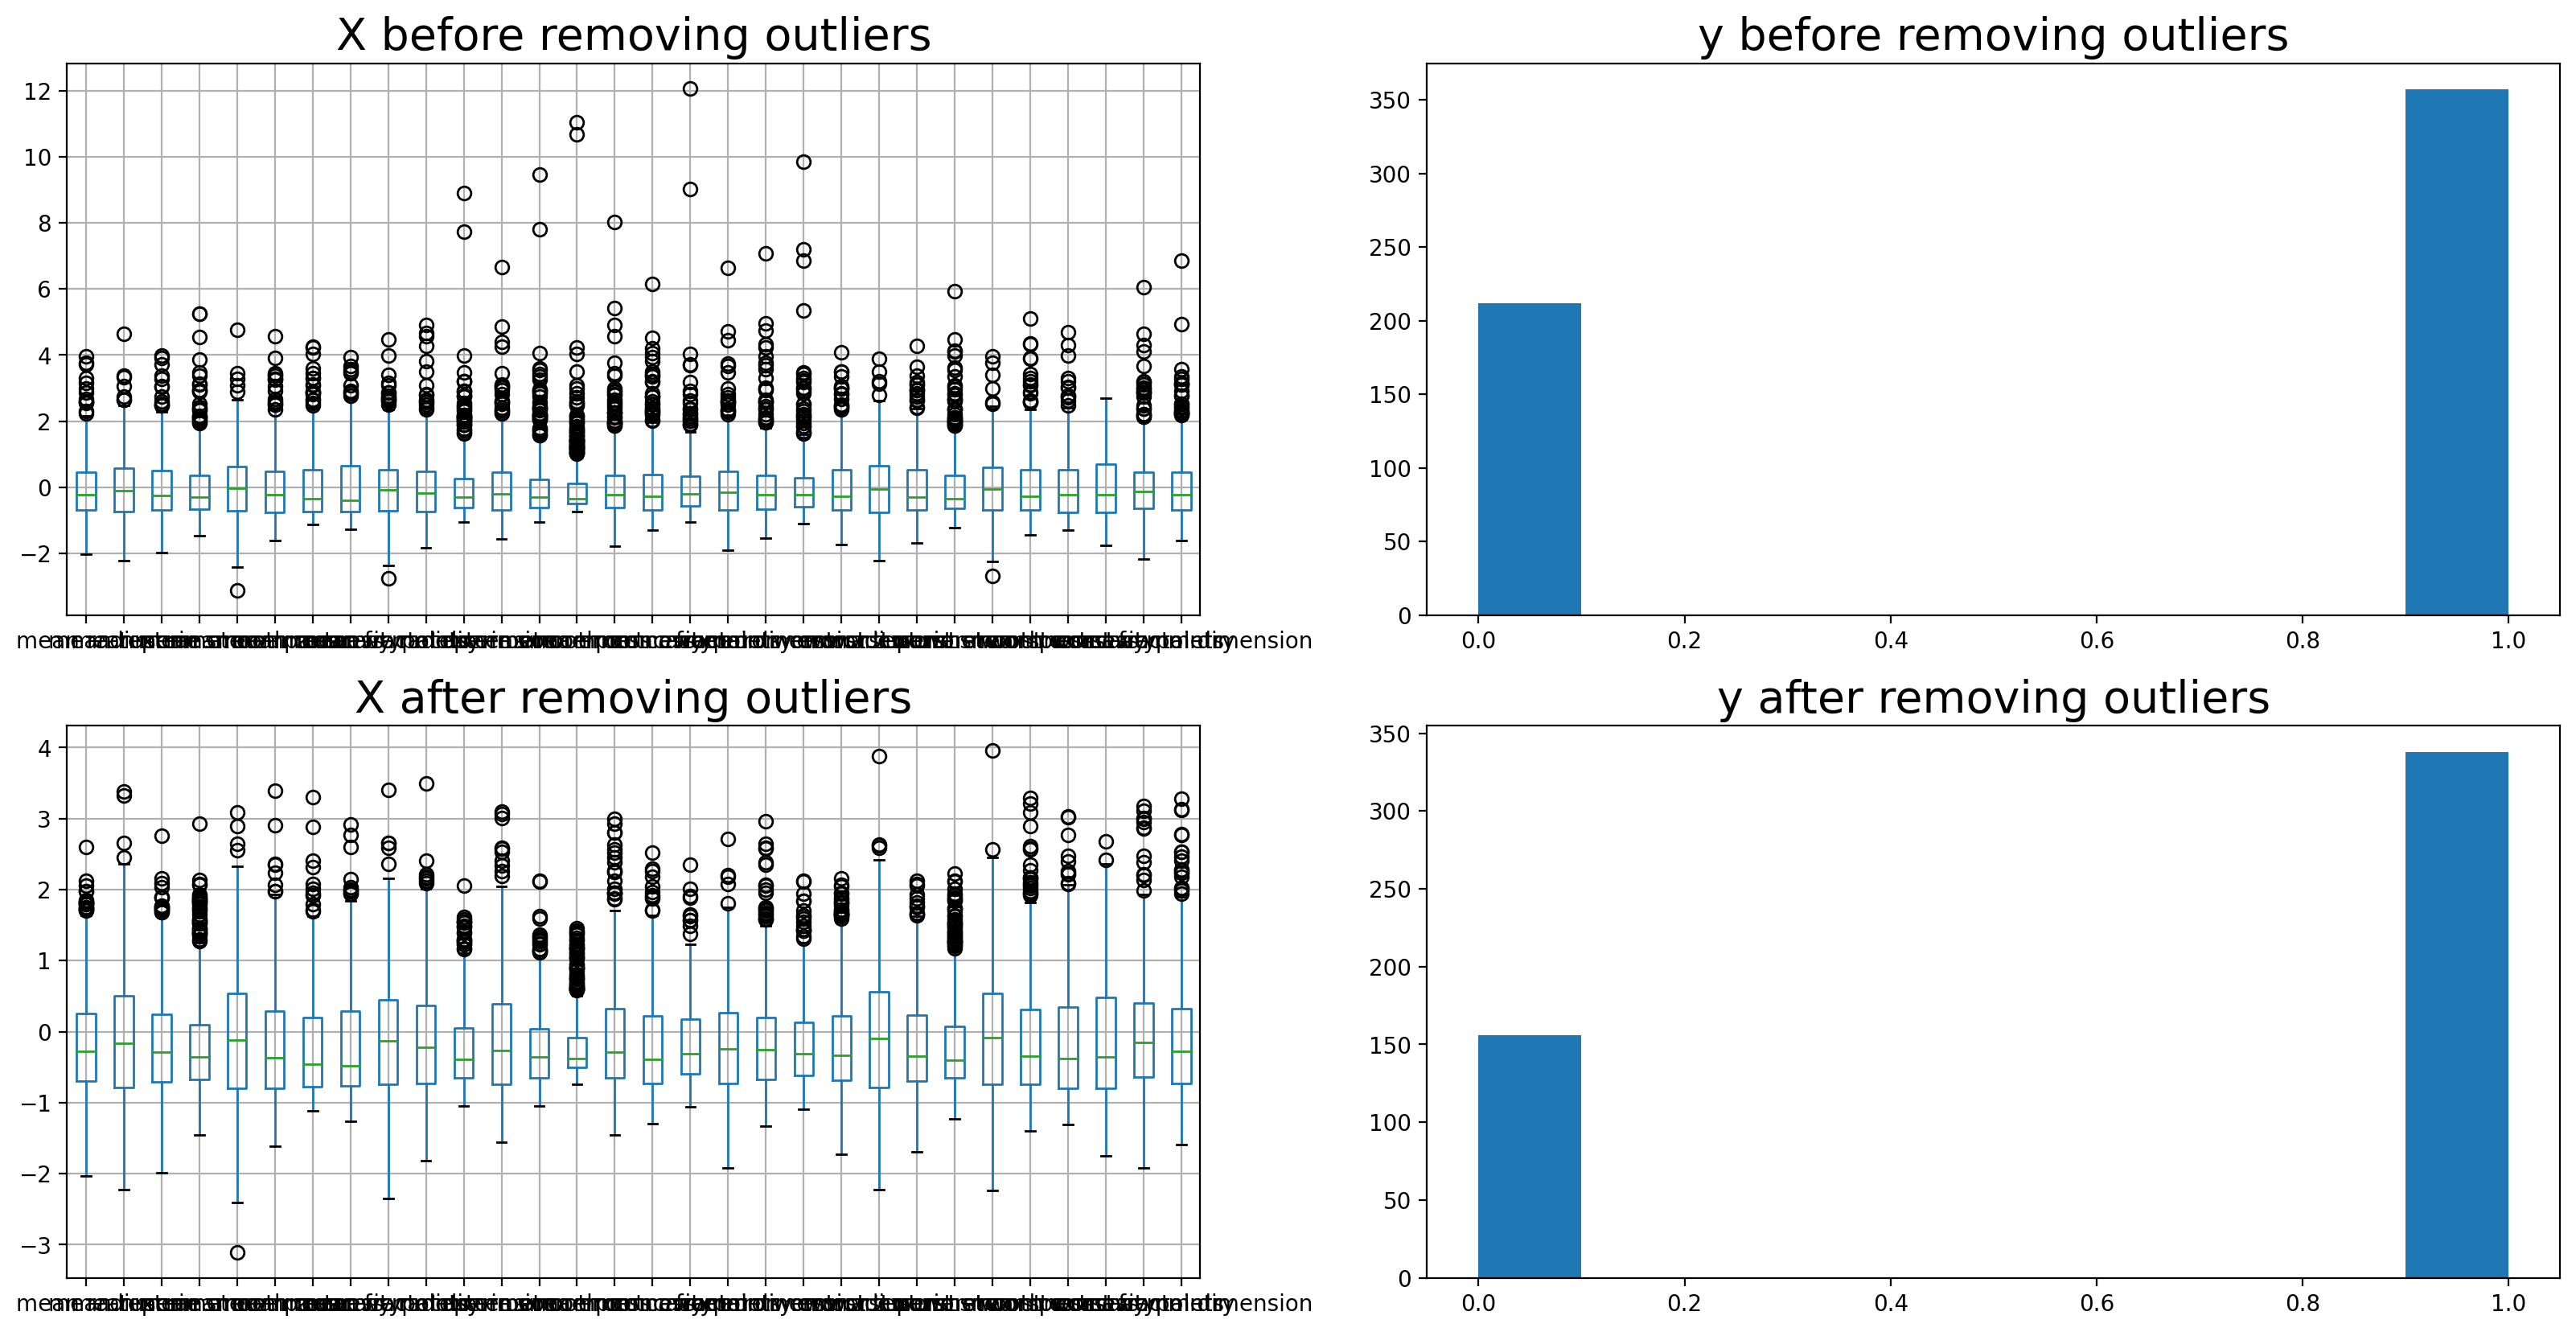

In [13]:
# data distribution after removing outliers

fig = plt.figure(figsize = (20,10), dpi = 200)

ax = fig.add_subplot(2,2,1)
X_scaled.boxplot()
plt.title('X before removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,2)
plt.hist(y)
plt.title('y before removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,3)
X_clean.boxplot()
plt.title('X after removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,4)
plt.hist(y_clean)
plt.title('y after removing outliers', fontsize = 20)

## 3. Training Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_clean,y_clean, test_size = 0.33, random_state = 42)

## 4. Features Selection using Lasso Regularization with parameter C found by k-folds CV

We use penalty **'l1' to implement Lasso regularization**, for wich the coefficients of the features which are not relevant are set to 0. **The strenght of the regularization is given by the inverse of the parameter C**: the lower C, the stronger the regularization.

Text(0, 0.5, 'Cross-Val Accuracy')

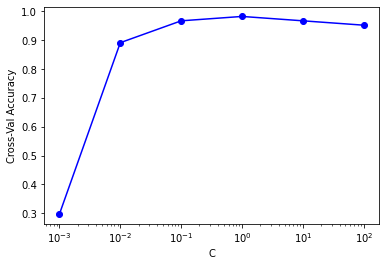

In [16]:
cv = 10

C_values = [0.001, 0.01, 0.1, 1.0, 10, 100]

cv_score = []

penalty = 'l1' # Lasso regularization
solver = 'liblinear'  # we need 'liblinear' to implement 'l1' norm
fit_intercept = True

for C in C_values:
    


    log_reg = LogisticRegression(penalty = penalty, 
                                solver = solver,
                                 C = C, 
                                 fit_intercept = fit_intercept)
    
    cross_val = cross_val_score(estimator = log_reg, X = X_train.values, y = y_train.values.ravel(), cv = cv)
    
    cv_score.append(np.average(cross_val))
    
    
plt.plot(np.array(C_values),np.array(cv_score),'bo-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Cross-Val Accuracy')

In [17]:
penalty = 'l1' # Lasso regularization
solver = 'liblinear'  # we need 'liblinear' to implement 'l1' norm
C = 1
fit_intercept = True


log_reg = LogisticRegression(penalty = penalty, 
                             solver = solver,
                             C = C, 
                             fit_intercept = fit_intercept)

log_reg.fit(X_train,y_train.values.ravel())

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [18]:
def get_lasso_log_reg(log_reg,X):
    
    imortant_features = X.columns[np.where(log_reg.coef_[0] !=0)[0]]
    
    X = X[imortant_features]
    
    return X

In [19]:
X_train_lasso_log_reg = get_lasso_log_reg(log_reg,X_train)
X_test_lasso_log_reg = get_lasso_log_reg(log_reg,X_test)

In [20]:
X_train_lasso_log_reg

,mean concavity,mean concave points,radius error,smoothness error,compactness error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst concavity,worst concave points
447,0.855002,1.175970,0.504307,-0.288338,-0.374915,-0.599617,-0.404693,1.157759,0.085131,1.040681,1.076575,0.737820,0.497558,0.554153
108,2.080367,1.701909,0.325291,-0.669353,0.352767,-0.576612,-0.215945,1.317213,1.286918,1.234289,1.245335,-0.213419,1.415804,0.892184
37,0.424367,0.631459,-0.426147,-0.169667,-0.118382,-0.376832,-0.057458,-0.124082,0.370108,-0.132881,-0.213029,2.026595,1.095810,1.434251
157,-0.819454,-0.861239,-0.791399,0.263351,-0.933475,1.313423,-0.683464,-0.766038,0.130727,-0.824806,-0.687490,0.141652,-0.883505,-1.089406
460,-0.451719,-0.116567,0.119927,-0.151332,-0.409566,-0.265440,-0.558641,-0.573451,0.374993,-0.558223,-0.577093,0.110966,-0.650489,-0.207176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.049099,0.189608,1.026560,-0.871028,0.102382,-0.029337,-0.419444,1.253017,0.008594,1.219396,1.155681,-1.326851,0.232735,0.109537
270,-0.946385,-0.823580,-0.098791,0.105345,-0.820913,1.669394,-0.315425,-0.697700,-0.890303,-0.759575,-0.641081,-2.116335,-1.198510,-1.313846
348,0.392979,1.014241,0.175148,0.063343,0.125297,-0.775181,-0.173581,0.996235,-0.043516,0.918559,0.823436,0.693984,0.277832,1.260668
435,0.588837,0.481596,0.252385,0.879709,0.731139,0.459820,1.210441,-0.053674,1.182698,-0.037566,-0.162753,2.061664,0.316212,0.570903


## 5. Fit KNN with parameters from k-folds CV

Documentation page KNN:

https://scikit-learn.org/stable/modules/neighbors.html

In [21]:
n_neighbors = [5,10, 50, 100, 150, 200] # Number of neighbors to use by default for kneighbors queries.


weights = ['uniform','distance'] # {‘uniform’, ‘distance’} or callable
                                 
                                 # ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
         
                                 # ‘distance’ : weight points by the inverse of their distance. 
                                 #  In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.


                                 # [callable] : a user-defined function which accepts an array of distances, 
                                 # and returns an array of the same shape containing the weights.
                            
                            
#algorithm = ['ball_tree', 'kd_tree', 'brute']  # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’

                                               # Algorithm used to compute the nearest neighbors:
    
                                               # if 'default', it automaticallu picks the best one
    
algorithm = 'default'


leaf_size = [2, 5,10, 50, 100] # Leaf size passed to BallTree or KDTree. 
                          # This can affect the speed of the construction and query, 
                           # as well as the memory required to store the tree. 
                           # The optimal value depends on the nature of the problem.

p = [1,2]  # Power parameter for the Minkowski metric. 
           # p = 1, this is equivalent to using manhattan_distance (l1), 
           # p = 2, this is equivakent to using euclidean_distance (l2) 
        

metric = 'minkowsky' # the distance metric to use for the tree. 
                     # The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric. 
                     # See the documentation of DistanceMetric for a list of available metrics. 
                     # If metric is “precomputed”, X is assumed to be a distance matrix and must be square during fit. 
                     # X may be a sparse graph, in which case only “nonzero” elements may be considered neighbors.


n_jobs = 16


param_grid = {'n_neighbors': n_neighbors,
             'weights': weights, 
             'leaf_size': leaf_size,
             'p': p}


estimator = KNeighborsClassifier()

cv = 10
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = cv)

grid_search.fit(X_train_lasso_log_reg, y_train.values.ravel())


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [2, 5, 10, 50, 100],
                         'n_neighbors': [5, 10, 50, 100, 150, 200], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [22]:
grid_search.best_params_

{'leaf_size': 2, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

In [23]:
print('best 100-folds knn score: {:.3f}'.format(grid_search.best_score_))

best 100-folds knn score: 0.970


In [25]:
knn = KNeighborsClassifier(n_neighbors = 10,
                           weights = 'uniform',
                           leaf_size = 2,
                           p = 2)

knn.fit(X_train_lasso_log_reg,y_train.values.ravel())

KNeighborsClassifier(leaf_size=2, n_neighbors=10)

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95        98
         1.0       0.97      0.99      0.98       232

    accuracy                           0.97       330
   macro avg       0.97      0.96      0.97       330
weighted avg       0.97      0.97      0.97       330



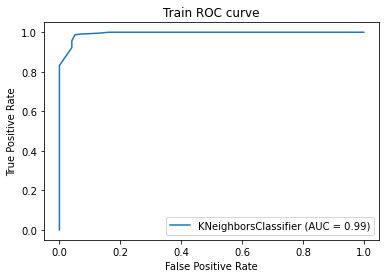

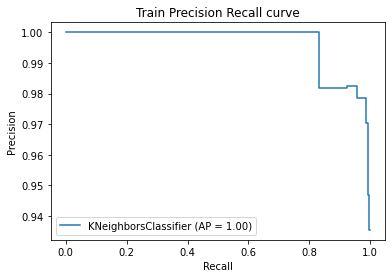

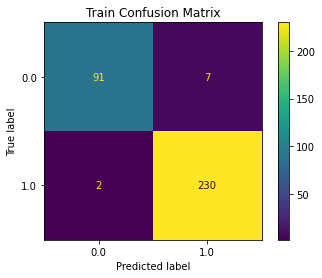

In [27]:
plot_classification_performance(knn,X_train_lasso_log_reg,y_train, step = 'Train', binary = 'False')

Test Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        58
         1.0       0.95      1.00      0.98       106

    accuracy                           0.97       164
   macro avg       0.98      0.96      0.97       164
weighted avg       0.97      0.97      0.97       164



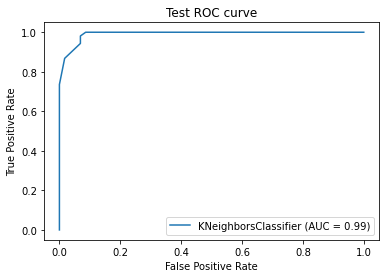

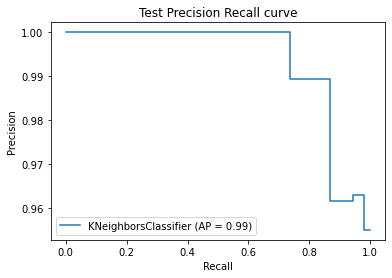

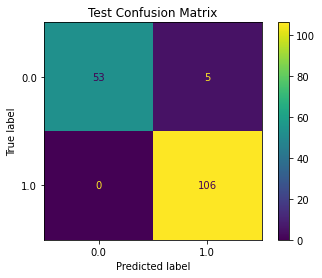

In [29]:
plot_classification_performance(knn,X_test_lasso_log_reg,y_test, step = 'Test', binary = 'False')

## 5. Fit KNN on number of features filtered by importance from RF and find the optimal number of features with k-folds CV

In [30]:
def get_RF_features_importances(rf,X,feature_threshold, plot):
    
    features_names = X.columns
    
    data = {'feature_name' : features_names,'feature_importance' : rf.feature_importances_}
    
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by = ['feature_importance'], ascending=False,inplace=True)
    
    selected_features = fi_df['feature_name'].values[:feature_threshold]
    
    X_rf = X[selected_features]
    
    if plot:

        #Define size of bar plot
        plt.figure(figsize = (10,8))
        #Plot Searborn bar chart
        sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_name'])
        #Add chart labels
        plt.title('Random Forest Feature Importance')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Name')
    

    return X_rf

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Text(0, 0.5, 'Cross-Val Accuracy')

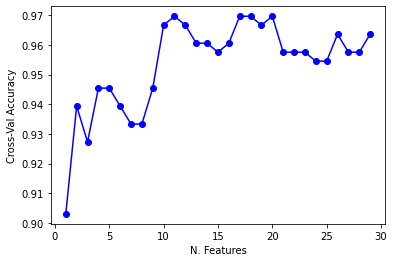

In [32]:
# find the optimal number of features to be selected

rf = RandomForestClassifier()

rf.fit(X_train, y_train)


cv = 10

feature_threshold = np.arange(1,30)

cv_score = []

for ft in feature_threshold:
    
    X_train_rf = get_RF_features_importances(rf, X_train, ft, plot = False)
    
    cross_val = cross_val_score(estimator = knn, X = X_train_rf.values, y = y_train.values.ravel(), cv = cv)
    
    cv_score.append(np.average(cross_val))
    
    
plt.plot(feature_threshold,np.array(cv_score),'bo-')
plt.xlabel('N. Features')
plt.ylabel('Cross-Val Accuracy')

In [33]:
# extract from the train and test datasets the relevant features found with k-folds cv

ft = 11

X_train_rf = get_RF_features_importances(rf, X_train, ft, plot = False)
X_test_rf = get_RF_features_importances(rf, X_test, ft, plot = False)

In [36]:
X_train_rf

,worst concave points,worst perimeter,mean concave points,worst radius,worst area,mean concavity,worst concavity,mean area,mean perimeter,worst texture,area error
447,0.554153,1.040681,1.175970,1.157759,1.076575,0.855002,0.497558,1.129424,1.187553,0.085131,0.594550
108,0.892184,1.234289,1.701909,1.317213,1.245335,2.080367,1.415804,1.527599,1.582979,1.286918,0.505884
37,1.434251,-0.132881,0.631459,-0.124082,-0.213029,0.424367,1.095810,-0.342115,-0.246689,0.370108,-0.353943
157,-1.089406,-0.824806,-0.861239,-0.766038,-0.687490,-0.819454,-0.883505,-0.642736,-0.687837,0.130727,-0.569120
460,-0.207176,-0.558223,-0.116567,-0.573451,-0.577093,-0.451719,-0.650489,-0.659801,-0.662299,0.374993,-0.212912
...,...,...,...,...,...,...,...,...,...,...,...
106,0.109537,1.219396,0.189608,1.253017,1.155681,0.049099,0.232735,1.374017,1.294648,0.008594,0.899714
270,-1.313846,-0.759575,-0.823580,-0.697700,-0.641081,-0.946385,-1.198510,-0.505082,-0.550673,-0.890303,-0.201911
348,1.260668,0.918559,1.014241,0.996235,0.823436,0.392979,0.277832,0.957925,1.063983,-0.043516,0.208420
435,0.570903,-0.037566,0.481596,-0.053674,-0.162753,0.588837,0.316212,-0.167771,0.014868,1.182698,-0.028318


## 6. Fit KNN on RF dataset with parameters from k-folds CV


In [39]:
estimator = KNeighborsClassifier()

cv = 10
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = cv)

grid_search.fit(X_train_rf, y_train.values.ravel())


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [2, 5, 10, 50, 100],
                         'n_neighbors': [5, 10, 50, 100, 150, 200], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [40]:
grid_search.best_params_

{'leaf_size': 2, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

In [38]:
print('best 100-folds knn score: {:.3f}'.format(grid_search.best_score_))

best 100-folds knn score: 0.973


In [42]:
knn = KNeighborsClassifier(n_neighbors = 5,
                           weights = 'uniform',
                           leaf_size = 2,
                           p = 2)

knn.fit(X_train_rf,y_train.values.ravel())

KNeighborsClassifier(leaf_size=2)

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96        98
         1.0       0.98      0.99      0.99       232

    accuracy                           0.98       330
   macro avg       0.98      0.97      0.97       330
weighted avg       0.98      0.98      0.98       330



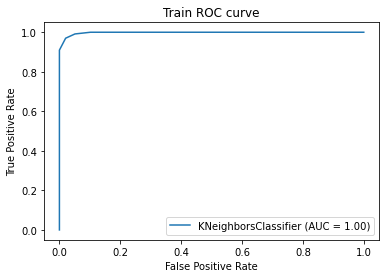

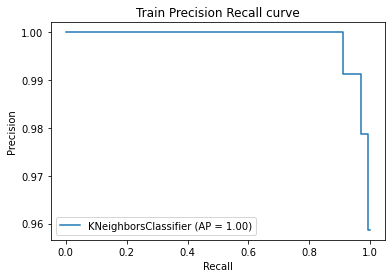

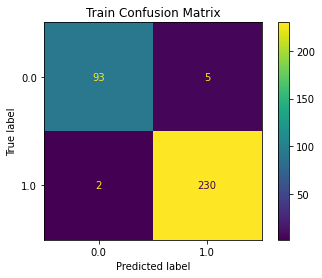

In [43]:
plot_classification_performance(knn,X_train_rf,y_train, step = 'Train', binary = 'False')

Test Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93        58
         1.0       0.98      0.94      0.96       106

    accuracy                           0.95       164
   macro avg       0.94      0.95      0.95       164
weighted avg       0.95      0.95      0.95       164



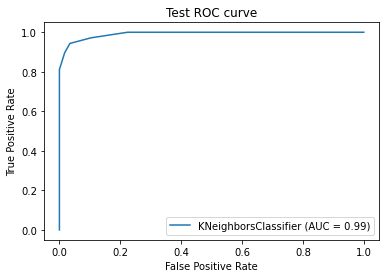

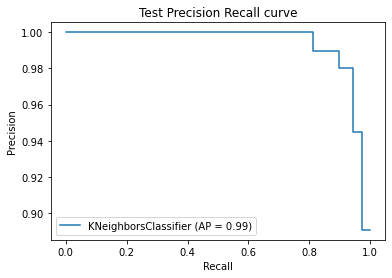

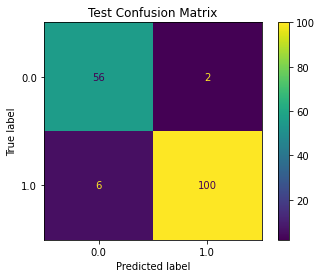

In [44]:
plot_classification_performance(knn,X_test_rf,y_test, step = 'Test', binary = 'False')